In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime
import urllib.parse

def get_smear_data(days_to_fetch = 3, variables_to_fetch = ['HYY_META.Tmm168', 'HYY_META.RH168']):
    '''This function will fetch the observational data from Hyytiälä weather station.'''

    # Check the list of stations
    url = "https://smear-backend.2.rahtiapp.fi/search/station"
    response = requests.get(url)
    print(response)

    if response.status_code == 200:
        print(f"Stations available through the API")
        data = response.json()
        for i in data:
            print(i)

    # Try to fetch the temperature data from 16.8 meters above ground level for the past two days
    datetime_start = datetime.datetime(year=2025, month=2, day=12, hour=0)
    num_days_to_fetch = datetime.timedelta(days = days_to_fetch)

    datetime_end = (datetime_start + num_days_to_fetch).isoformat()
    datetime_start = datetime_start.isoformat()

    print(f"\nFetching data from {datetime_start} to {datetime_end}.")

    dt_start = urllib.parse.quote_plus(datetime_start)
    dt_end = urllib.parse.quote_plus(datetime_end)

    # Formulate the url string
    fetch_request = "https://smear-backend.2.rahtiapp.fi/search/timeseries?aggregation=ARITHMETIC"

    # Add starting datetime
    fetch_request += "&from=" + dt_start

    # Add length of interval between data points (in minutes, 1-60)
    fetch_request += "&interval=60"
    # Add quality (ANY or CHECKED)
    fetch_request += "&quality=ANY"

    # Add request variables
    for var in variables_to_fetch:
        fetch_request += "&tablevariable=" + var

    # Finally, add the ending datetime
    fetch_request += "&to=" + dt_end

    print(f"Using the following URL:\n{fetch_request}")

    #fetch_request = "https://smear-backend.2.rahtiapp.fi/search/timeseries?aggregation=ARITHMETIC&from=2025-02-08T00%3A00%3A00.000&interval=60&quality=ANY&tablevariable=HYY_META.Tmm168&to=2025-02-09T00%3A00%3A00.000"

    response = requests.get(fetch_request)

    if response.status_code == 200:
        # Fetch OK, let's plot
        data = response.json()

        print(data)

        # A dictionary is returned, data will contain the measurements with time stamps
        df = pd.DataFrame.from_dict(data['data'])

        # Transform the time stamp into a default datetime format, assign it as an index
        df['datetime'] = pd.to_datetime(df['samptime'], errors = 'coerce')
        df.set_index('datetime', inplace = True)
        df.drop(columns = 'samptime', inplace = True)

        return df
    else:
        print(f"unsuccesfull")
        return pd.DataFrame()


get_smear_data()

<Response [200]>
Stations available through the API
{'dcmiPoint': 'name=Värriö; east=29.610137; north=67.755044; elevation=395;', 'id': 1, 'name': 'Värriö'}
{'dcmiPoint': 'name=Hyytiälä; east=24.294795; north=61.847463; elevation=179;', 'id': 2, 'name': 'Hyytiälä'}
{'dcmiPoint': 'name=Kumpula; east=24.961227; north=60.202887; elevation=30;', 'id': 3, 'name': 'Kumpula'}
{'dcmiPoint': 'name=Puijo; east=27.655278; north=62.909444; elevation=306;', 'id': 4, 'name': 'Puijo'}
{'dcmiPoint': 'name=Erottaja; east=24.9454; north=60.1652; elevation=23;', 'id': 5, 'name': 'Erottaja'}
{'dcmiPoint': 'name=Torni; east=24.9387; north=60.1678; elevation=15;', 'id': 6, 'name': 'Torni'}
{'dcmiPoint': 'name=Siikaneva 1; east=24.192794; north=61.832702; elevation=162;', 'id': 7, 'name': 'Siikaneva 1'}
{'dcmiPoint': 'name=Siikaneva 2; east=24.169752; north=61.837286; elevation=162;', 'id': 8, 'name': 'Siikaneva 2'}
{'dcmiPoint': 'name=Kuivajärvi; east=24.282; north=61.846; elevation=141;', 'id': 9, 'name': 

,HYY_META.RH168,HYY_META.Tmm168
datetime,,
2025-02-12 00:00:00,99.980000,-3.433694
2025-02-12 01:00:00,99.980000,-3.397528
2025-02-12 02:00:00,99.980000,-3.415556
2025-02-12 03:00:00,99.980000,-3.469222
2025-02-12 04:00:00,99.980000,-3.479125
...,...,...
2025-02-14 19:00:00,96.585167,-6.630833
2025-02-14 20:00:00,96.761028,-6.750847
2025-02-14 21:00:00,96.894334,-6.895807


In [ ]:
VARIABLES_TO_FETCH = ['HYY_DMPS.tconc',     # Total particle concentration (placeholder)
                      'HYY_META.Tmm168',    # Temperature, 16.8 m
                      'HYY_META.RH168',     # Relative humidity, 16.8 m
                      'HYY_META.WDU84',     # Wind direction 8.4 m
                      'HYY_META.WSU84',     # Wind speed 8.4 m
                      'HYY_META.Precipacc'] # Precipitation

# 'HYY_META.O384', 'HYY_META.NOx84' -> No response from the server, web API does not show any data either for any NOx/O3 variable
df = get_smear_data(days_to_fetch=3,variables_to_fetch=VARIABLES_TO_FETCH)

variables_to_fetch = df.columns#.drop(columns='datetime').columns
N_variables = len(variables_to_fetch)

fig, axs = plt.subplots(N_variables,1, figsize=(8,5*N_variables))
for i in range(N_variables):
    axs[i].plot(df.index, df[variables_to_fetch[i]], label= variables_to_fetch[i])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(variables_to_fetch[i])
    #axs[i].set_xticks([])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=30, ha='right')
    axs[i].legend()
    axs[i].grid()

In [ ]:

import matplotlib.colors as mcolors
import matplotlib.cm as cmx

def plot_wind_rose(direction, speed, direction_bins, speed_bins, plot_title):
    # Normalize direction to be within 0-360 degrees
    direction = np.mod(direction, 360)

    # Create the wind rose figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, polar=True)

    # Compute histogram
    hist, _, _ = np.histogram2d(direction, speed, bins=[direction_bins, speed_bins])

    # Create a colormap
    cmap = plt.get_cmap('viridis')
    c_norm = mcolors.Normalize(vmin=min(speed_bins), vmax=max(speed_bins))
    scalar_map = cmx.ScalarMappable(norm=c_norm, cmap=cmap)

    # Define the width of each bar in radians
    width = np.deg2rad(np.diff(np.mod(direction_bins, 360)))

    # Adjust direction bins to match histogram shape
    direction_bins_wrapped_ = np.deg2rad(direction_bins_wrapped[:-1])

    # Plot each speed bin as a bar
    x = [4,3,2,1,0]
    for i in x:
        bars = ax.bar(
            direction_bins_wrapped_, hist[:, i],
            width=width, color= scalar_map.to_rgba(speed_bins[i]),
            edgecolor='k', align='edge'
        )


    # Add color bar
    cbar = fig.colorbar(scalar_map, ax=ax, orientation='vertical', pad=0.1, extend='both')
    cbar.set_label('Wind Speed (m s$^{-1}$)', fontsize=18)

    # Add labels and title
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(plot_title, fontweight='bold', fontsize=21)

    # Fix ticks to ensure 'N' is displayed
    tick_locs = np.linspace(0, 2*np.pi, num=8, endpoint=False)
    tick_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, fontsize=12)

    ax.set_yticks([])
    #fig.savefig('../figures/windrose_windspeed_in.png', dpi=500)
    plt.show()

direction_bins = np.arange(-15, 360, 30)
direction_bins_wrapped = np.mod(direction_bins, 360)
speed_bins = [0,0.25,0.5,1,1.5,2]
direction = df["HYY_META.WDU84"]
speed = df["HYY_META.WSU84"]
plot_wind_rose(direction, speed, direction_bins, speed_bins, "Hyytiälä station")

In [ ]:
import xarray as xr
from netCDF4 import Dataset
from pandas.tseries.offsets import DateOffset

def load_chimere_data(file):
    # Load model output
    data = xr.open_dataset(file, engine="netcdf4")

    # Define the time in common format with reference observations
    #data['datetime'] = pd.to_datetime(data['Times'].values, errors = 'coerce')

    # Drop the old time column
    #data.drop(columns = 'Time', inplace = True)

    # Shift to Helsinki time zone, GMT + 2
    # ...

    # Define as index
    #data.set_index(data['datetime'], inplace = True)

    return data


df = load_chimere_data('val_data_2025_02_12.nc')
#df = load_chimere_data("../CHIMERE/chimere_forecast/nest-FINLAND6-forecast/chim_nest-FINLAND6-forecast_2025012900_72_out.nc")

#ds = xr.open_dataset("../CHIMERE/chimere_forecast/nest-FINLAND6-forecast/chim_nest-FINLAND6-forecast_2025012900_72_out.nc", engine="netcdf4")

In [42]:
import xarray as xr
from netCDF4 import Dataset
from pandas.tseries.offsets import DateOffset
import numpy as np

MAGIC_LON = 43  # Magic number to reduce number of find_nearest calls to one
MAGIC_LAT = 52  # Magic number to reduce number of find_nearest calls to one
HYYTIALA_LON = 24.294795
HYYTIALA_LAT = 61.847463

def find_nearest(array, value):
    '''Helper function to select the grid point from the simulation output containing Hyytiälä measurement station'''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

chd = xr.open_dataset("val_data_2025_02_12.nc", engine="netcdf4")
#load_chimere_data("dummy.nc")

# Pick up the grid point corresponds to Hyytiälä
idx_lon = find_nearest(chd.nav_lon[MAGIC_LON, :], HYYTIALA_LON)
idx_lat = find_nearest(chd.nav_lat[:, MAGIC_LAT], HYYTIALA_LAT)

# Get the measurements of interest, bottom_top corresponds to the vertical layer number
VERT_LAYER_NUM = 1
ch_wind_zonal = chd.winz.sel(bottom_top = VERT_LAYER_NUM).sel(x = idx_lon).sel(y = idx_lat)
ch_wind_meridional = chd.winm.sel(bottom_top = VERT_LAYER_NUM).sel(x = idx_lon).sel(y = idx_lat)
ch_temperature = chd.temp.sel(bottom_top = VERT_LAYER_NUM).sel(x = idx_lon).sel(y = idx_lat)
ch_relhum = chd.sreh.sel(x = idx_lon).sel(y = idx_lat)      # Surface relative humidity ok?
ch_precip = chd.topc.sel(x = idx_lon).sel(y = idx_lat)     # Total preicipitation ok?
ch_pm25 = chd.PM25.sel(bottom_top = VERT_LAYER_NUM).sel(x = idx_lon).sel(y = idx_lat)


In [43]:
np.max(df['HYY_DMPS.tconc'])

1418.7150065104167

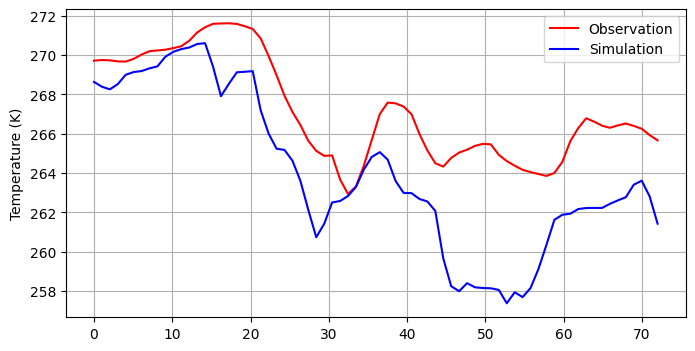

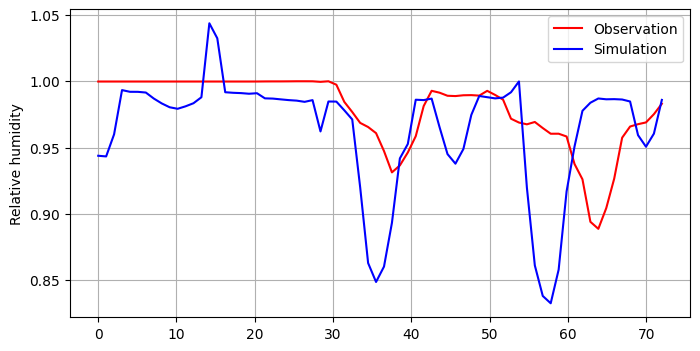

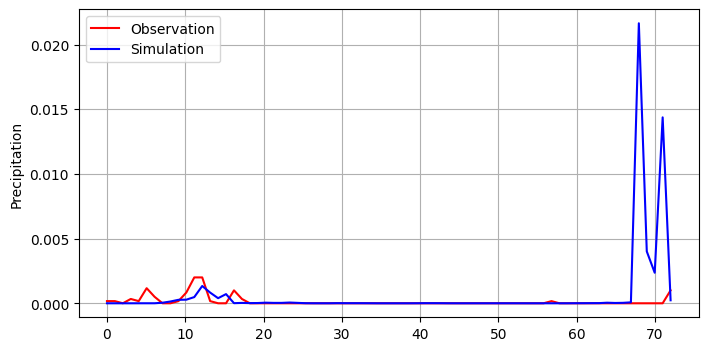

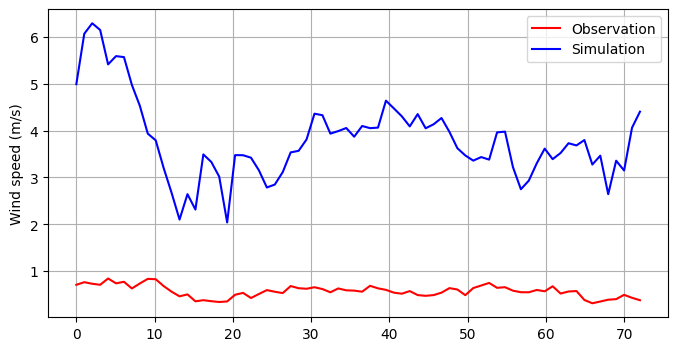

In [46]:
# PLOTTING

def compute_MAE(actual, predicted):
    '''Helper function for computed the mean absolute error (MAE) between two arrays'''
    return np.sum(np.abs(actual-predicted))/len(actual)

def plot_validation(time = np.array([x for x in range(100)]), chim = np.array([x**2.1 for x in range(100)]), obs = np.array([x**2 for x in range(100)]), label='y-axis', fig_name = 'dummy.png'):
    plt.figure(figsize = (8,4))
    plt.plot(np.linspace(0, len(obs), len(obs)), obs, color='red', label='Observation')
    plt.plot(np.linspace(0, len(chim), len(chim)), chim, color='blue', label='Simulation')
    plt.legend()
    #plt.title(f"Forecast validation, MAE={compute_MAE(obs, chim)}")
    plt.ylabel(label)
    fig.autofmt_xdate(rotation=45)
    plt.grid()
    plt.savefig(fig_name, dpi = 350, bbox_inches='tight')
    plt.show()

plot_validation(chd.Times, ch_temperature, df['HYY_META.Tmm168'] + 273.15, 'Temperature (K)', 'validation_temp_2025_02_12.png')
plot_validation(chd.Times, ch_relhum, df['HYY_META.RH168']/100, 'Relative humidity', 'validation_relhum_2025_02_12.png')
plot_validation(chd.Times, ch_precip, df['HYY_META.Precipacc'], 'Precipitation', 'validation_precip_2025_02_12.png')
plot_validation(chd.Times, np.sqrt(ch_wind_meridional**2 + ch_wind_zonal**2), df['HYY_META.WSU84'], 'Wind speed (m/s)', 'validation_windsp_2025_02_12.png')
#plot_validation(chd.Times, ch_pm25, df['HYY_DMPS.tconc']/1000, 'Particle matter (bad observation)')